## Fit and analyze autoencoders
The first step of the BehaveNet pipeline is to compress the behavioral videos with a convolutional autoencoder (CAE), yielding a low-dimensional continuous representation of behavior that is useful for downstream analyses.

Because the CAEs currently require significant computation time (generally >12 hours on a GPU) the data downloaded in the previous notebook also contains already trained CAEs, which we will analyze here.

There are a variety of files that are automatically saved during the fitting of a CAE, which can be used for later analyses such as those below. Some of these files (many of which are common to all BehaveNet models, not just the CAE):
* `best_val_model.pt`: the best CAE (not necessarily from the final training epoch) as determined by computing the loss on validation data
* `meta_tags.csv`: hyperparameters associated with data, computational resources, and model
* `metrics.csv`: metrics computed on dataset as a function of epochs; the default is that metrics are computed on training and validation data every epoch (and reported as a mean over all batches) while metrics are computed on test data only at the end of training using the best model (and reported per batch).
* `[lab_id]_[expt_id]_[animal_id]_[session_id]_latents.pkl`: list of np.ndarrays of CAE latents computed using the best model
* `session_info.csv`: sessions used to fit the model

To fit your own CAEs, see additional documentation [here](https://behavenet.readthedocs.io/en/latest/source/user_guide.autoencoders.html). The downloaded CAEs used the default architecture with 9 latents, a learning rate of 1e-4, and no regularization. Models fit to individual datasets were trained for 600 epochs, while the model fit to both datasets was trained for 300 epochs.

**Note**: The BehaveNet models are trained on batches of data, which here are defined as one trial per batch; at 189 frames per trial, 2 camera views, and 128x128 images, a batch of data is of size (189, 2, 128, 128). For datasets that do not have a trial structure (i.e. spontaneous behavior) we recommend splitting frames into arbitrarily defined "trials", the length of which should depend on the autocorrelation of the behavior (i.e. trials should not be shorter than the temporal extent of relevant behaviors). For the NP dataset in the original paper we used batch sizes of 1000 frames (~25 sec).

<br>

### Contents
* [Plot train and val losses as a function of epochs](#Plot-train-and-val-losses-as-a-function-of-epochs)
* [Plot train/val losses as a function of dataset](#Plot-train/val-losses-as-a-function-of-dataset)
* [Make reconstruction movies](#Make-reconstruction-movies)

In [34]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
%matplotlib inline
save_outputs = True  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

## Plot train and val losses as a function of epochs
Note: plots similar to these can be automatically saved upon completion of CAE training by setting the `export_train_plots` option to `True` in the training json file.

[Back to contents](#Contents)

In [45]:
from behavenet.fitting.utils import read_session_info_from_csv

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'latent_search',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv',
    'n_ae_latents': 9,
}

# programmatically fill out other hparams options
get_lab_example(hparams, 'dipoppa', 'MSP_pupil')
hparams['session_dir'], sess_ids = get_session_dir(hparams)
hparams['expt_dir'] = get_expt_dir(hparams)

# find metrics csv file
#versions = get_best_model_version(hparams['expt_dir'])
version_dir = os.path.join(hparams['expt_dir'], 'version_%i' % 0)
metric_file = os.path.join(version_dir, 'metrics.csv')
metrics = pd.read_csv(metric_file)
metrics.head()
# collect data from csv file
sess_ids = read_session_info_from_csv(os.path.join(version_dir, 'session_info.csv'))
sess_ids_strs = []
for sess_id in sess_ids:
    sess_ids_strs.append(str('%s/%s' % (sess_id['animal'], sess_id['session'])))
metrics_df = []
for i, row in metrics.iterrows():
    dataset = 'all' if row['dataset'] == -1 else sess_ids_strs[row['dataset']]
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['val_loss'],
        'dtype': 'val',
    }, index=[0]))
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['tr_loss'],
        'dtype': 'train',
    }, index=[0]))
metrics_df = pd.concat(metrics_df)

EmptyDataError: No columns to parse from file

In [ ]:
# plot data
sns.set_style('white')
sns.set_context('talk')

data_queried = metrics_df[(metrics_df.epoch > 20) & ~pd.isna(metrics_df.loss)]
splt = sns.relplot(x='epoch', y='loss', hue='dtype', kind='line', data=data_queried)
splt.ax.set_xlabel('Epoch')
splt.ax.set_yscale('log')
splt.ax.set_ylabel('MSE per pixel')

if save_outputs:
    save_file = os.path.join(get_user_dir('fig'), 'ae', 'loss_vs_epoch')
    make_dir_if_not_exists(save_file)
    plt.savefig(save_file + '.' + format, dpi=300, format=format)

plt.show()

## Plot train/val losses as a function of dataset
In the previous section we plotted training and validation losses for a CAE trained on a single experimental session, which was defined by the call to `get_lab_example()`; this function uses the example dataset defined in the `.behavenet/musall_vistrained_params` json file (`05-Dec-2017`). To choose the other dataset, you can modify the above cell like so:
```python
...
get_lab_example(hparams, 'musall', 'vistrained')
hparams['session'] = '07-Dec-2017'  # <- add this line
...
```

There is a third option, which is to plot performance of the model trained on both datasets simultaneously:
```python
...
get_lab_example(hparams, 'musall', 'vistrained')
hparams['session'] = 'multisession-00'
...
```

The session name `multisession-00` is a bit cryptic - with many datasets, this would correspond to only one of many different combinations. The datasets which are associated with this multisession dataset can be found in the `session_info.csv` file inside the multisession directory, i.e. `save_dir/musall/vistrained/mSM36/multisession-00/session_info.csv`. 

Below we will plot CAE performance on both datasets throughout training. [Note that this CAE was trained using half the number of epochs as the previous one since there was twice as many batches when combining the datasets.]

[Back to contents](#Contents)

In [46]:
from behavenet.fitting.utils import read_session_info_from_csv

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'latent_search',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv',
    'n_ae_latents': 9,
}

# programmatically fill out other hparams options
get_lab_example(hparams, 'dipoppa', 'MSP_pupil')
hparams['session'] = '1'
hparams['session_dir'], sess_ids = get_session_dir(hparams)
hparams['expt_dir'] = get_expt_dir(hparams)

# find metrics csv file
#versions = get_best_model_version(hparams['expt_dir'])
version_dir = os.path.join(hparams['expt_dir'], 'version_%i' % 1)
metric_file = os.path.join(version_dir, 'metrics.csv')
metrics = pd.read_csv(metric_file)

# collect data from csv file
sess_ids = read_session_info_from_csv(os.path.join(version_dir, 'session_info.csv'))
sess_ids_strs = []
for sess_id in sess_ids:
    sess_ids_strs.append(str('%s/%s' % (sess_id['animal'], sess_id['session'])))
metrics_df = []
for i, row in metrics.iterrows():
    dataset = 'Combined' if row['dataset'] == -1 else sess_ids_strs[row['dataset']]
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['val_loss'],
        'dtype': 'val',
    }, index=[0]))
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['tr_loss'],
        'dtype': 'train',
    }, index=[0]))
metrics_df = pd.concat(metrics_df)

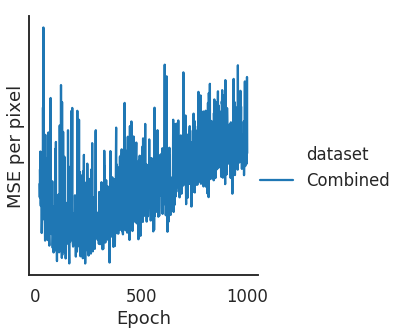

In [47]:
# plot data
sns.set_style('white')
sns.set_context('talk')

dtype = 'val'  # 'train' | 'val'
data_queried = metrics_df[
    (metrics_df.epoch > 20) & (metrics_df.dtype == dtype) & ~pd.isna(metrics_df.loss)]
splt = sns.relplot(x='epoch', y='loss', hue='dataset', kind='line', data=data_queried)
splt.ax.set_xlabel('Epoch')
splt.ax.set_yscale('log')
splt.ax.set_ylabel('MSE per pixel')
# plt.title('%s loss' % title_str)

if save_outputs:
    save_file = os.path.join(get_user_dir('fig'), 'ae', 'loss_vs_epoch_by_dataset')
    make_dir_if_not_exists(save_file)
    plt.savefig(save_file + '.' + format, dpi=300, format=format)

plt.show()

## Make reconstruction movies
The above plots are useful, for example, if you want to determine whether or not the model training completed satisfactorily. They are not useful, however, in understanding how good the reconstructions actually look. In order to do so BehaveNet has functionality to make reconstruction movies that contain the original video, the reconstructed video, and the residual.

[Back to contents](#Contents)

In [48]:
import logging
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.INFO)

Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_MSP_pupil_SB028_1
    signals: ['images', 'labels']
    transforms: OrderedDict([('images', None), ('labels', None)])
    paths: OrderedDict([('images', '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/SB028/1/data.hdf5'), ('labels', '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/SB028/1/data.hdf5')])

cond-ae-msp
Loading model defined in /home/samsung_2tb_ssd/yoni/results/dipoppa/MSP_pupil/SB028/1/cond-ae-msp/conv/09_latents/latent_search/version_1/meta_tags.pkl
Making directories for:  figures/ae-msp/SB028_aemsp_s1
saving video to figures/ae-msp/SB028_aemsp_s1.mp4...done


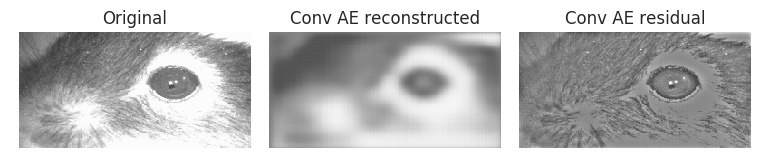

In [49]:
from behavenet.plotting.ae_utils import make_ae_reconstruction_movie_wrapper
from behavenet.data.utils import get_data_generator_inputs
from behavenet.data.data_generator import ConcatSessionsGenerator

# movie info
save_outputs = True
include_linear = False  # True to include reconstructions from linear models; need training

# set model info
version = 1  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
# hparams = {
#     'data_dir': get_user_dir('data'),
#     'save_dir': get_user_dir('save'),
#     'experiment_name': 'latent_search',
#     'ae_experiment_name': 'latent_search',
#     'model_class': 'cond-ae-msp',
#     'model_type': 'conv',
#     'n_ae_latents': 6,
#     'frame_rate': 20,  # frame rate of rendered movie, not original behavioral video
# }
# hparams = {
#     'data_dir': get_user_dir('data'),
#     'save_dir': get_user_dir('save'),
#     'model_class': 'neural-ae',
#     'experiment_name': 'grid_search',
#     'model_type': 'ff',
#     'ae_model_type': 'conv',
#     'noise_type': 'gaussian',
#     'n_arhmm_lags': 1,
#     'kappa': 0,
#     'arhmm_experiment_name': 'state_number_search',
#     'ae_experiment_name': 'latent_search',
#     'n_ae_latents': 9,
#     'neural_arhmm_experiment_name':'grid_search',
#     'n_arhmm_states': 4,
#     'n_max_lags': 8
# }

# programmatically fill out other hparams options


# load data generator to find a test trial
hparams, signals, transforms, paths = get_data_generator_inputs(hparams, sess_ids)
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], sess_ids, 
    signals_list=signals, transforms_list=transforms, paths_list=paths,
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
print(data_generator)
trial = data_generator.datasets[sess_idx].batch_idxs['test'][8]  # trial to use in movie

filename = str('SB028_aemsp_s1')
if include_linear:
    filename += '_wlinear'

make_ae_reconstruction_movie_wrapper(
    hparams, version='best', 
    save_file=os.path.join(get_user_dir('fig'), 'ae-msp', filename), 
    include_linear=include_linear, trial=trial)